# Sonic log - Dalbyover 59.459  

Reading LAS wireline log file, calculate sonic velocity from arrival times. 
 
The tool used for sonic logs have recievers at 0.60, 0.80 and 1.00m according to [factsheet](https://github.com/TobbeTripitaka/Dalbyover/blob/master/Sonic-slimhole_TRGS8068.pdf). The header of the [LAS files](https://github.com/TobbeTripitaka/Dalbyover/tree/master/data) states that the measurements are in _m_ and _km_. Modified sonic log used.  

The upper 40m, the most interesting depths fo us, is unfortunately missing. The well needed a steel casting to not collaps and sonic logs are not correct. 

Instructions: 

<blockquote>In [the] data set I have performed depth correction based on the strong gamma peaks in the lower part of the well, and using TCDS3719-Dalbyover1 as the reference because we know for certain that this well log was recorded from ground level. I had to adjust TRGS8068-Dalbyover4 up by 69 cm and TRGS8068-Dalbyover5 up by 7 cm. After depth correction I merged the two files at 113,68 m depth where their gamma values coincided.</blockquote>


In [2]:
#Plot in document
%matplotlib inline

import numpy as np
import pandas as pd

import numpy.lib.recfunctions
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import gridspec
import scipy.signal as signal
import math


First read in the datasets, wireline logs and plug samples:

Create a pandas dataframe, handy for plotting and statistical analysis. Plot an overview of the data. 

In [3]:
def read_LAS(file_name,file_header=33):
    '''
    Read LAS file from Robertson Geologging WinLogger
    Specify file name and header line nr.  
    '''
    in_file_A = pd.read_csv(file_name, header=file_header,delim_whitespace=True, 
                        na_values=['1.#J',0,-999.25,-999999.00000,'...'])
    
    # LAS files have an extra carachter that adds an extra column
    in_file = in_file_A[in_file_A.columns[:-1]]
    in_file.columns = in_file_A.columns[1:]
    in_file=in_file.dropna(axis=1,how='all')
    in_file[in_file < min_value] = np.nan
    return in_file
    
def read_porper(file_name):
    '''
    Read csv with data from plug samples.   
    '''
    in_file = pd.read_csv(file_name,usecols=['Plug', 'Depth','Volume',
                                             'Weight','Porosity','Density (grain)',
                                            'Density (bulk)', 'Permeability'])
    in_file.rename(columns={'Plug': 'ID', 'Depth': 'DEPTH','Volume': 'VOLUME', 'Weight': 'WEIGHT',
                           'Porosity': 'POROSITY', 'Density (grain)': 'GRAIN',
                            'Density (bulk)': 'BULK', 'Permeability' : 'PERMEABILITY'}, inplace=True)
    return in_file    

# In files 
in_sonic = 'data/59-459_Sonic3_Final04.LAS'
in_electric = ['data/TCDS3719-Dalbyover1.LAS', 'data/TCDS3719-Dalbyover2.LAS']
in_gamma = 'data/INDG1832-Dalbyover3.LAS'
#Old sonic logs: 'data/TRGS8068-Dalbyover5.LAS', 'data/TRGS8068-Dalbyover4.LAS'
#sonic = pd.concat([read_LAS(in_sonic[1],38), read_LAS(in_sonic[0],38)])

#Crop out negative values
min_value = -1

# Read and merge sonic logs
sonic = read_LAS(in_sonic,46)
sonic.columns = ['DEPTH', 'TXRX1','TXRX2','TXRX3','R1R2','R2R3','R1R3','SONIC','NGTR','NANA']

# Read and join electric logs
electric = pd.merge(read_LAS(in_electric[0]), read_LAS(in_electric[1]), 
                    on='DEPTH', how='outer',suffixes=('_E1', '_E2'))

# Read gamma log
gamma = read_LAS(in_gamma,32)
gamma.columns = ['DEPTH', 'NGAM_G','COND_G']

# Merge electric and gamma
el_gamma = pd.merge(electric, gamma, on='DEPTH', how='outer')

# and sonic
data = pd.merge(el_gamma, sonic, on='DEPTH', how='outer')

# and plug samples
porper = read_porper('data/Dalbyover-1 porperm.csv')
data = pd.merge(data, porper, on='DEPTH', how='outer')

data = data.sort_values('DEPTH', ascending=True)
data = data.dropna(axis=1,how='all')

# Save a file with sonic and electric data
data.to_csv('log_data.txt')

# How many meters did the cassing of the hole reach?
casing = 45

# Print overview
print list(data.columns.values), '\n'
print data.describe()
#print data.head()

['DEPTH', 'NGAM_E1', 'COND_E1', 'TEMP_E1', 'TEMP_E2', 'COND_E2', 'NGAM_E2', 'NGAM_G', 'COND_G', 'TXRX1', 'TXRX2', 'TXRX3', 'R1R2', 'R2R3', 'R1R3', 'SONIC', 'NGTR', 'NANA', 'ID', 'VOLUME', 'WEIGHT', 'POROSITY', 'GRAIN', 'BULK', 'PERMEABILITY'] 

              DEPTH       NGAM_E1       COND_E1       TEMP_E1       TEMP_E2  \
count  34896.000000  34586.000000  34557.000000  34561.000000  34605.000000   
mean     174.295050      8.890979    357.003930     10.499044     11.119097   
std      100.737624      4.674639    131.607944      1.630407      1.786431   
min       -0.190000      1.330000     10.860000      7.270000      8.380000   
25%       87.057500      6.100000    379.980000      8.770000      9.470000   
50%      174.295000      7.960000    401.860000     10.340000     11.130000   
75%      261.532500     10.340000    418.920000     12.020000     12.620000   
max      350.630000     67.800000   1604.930000     13.380000     14.600000   

            COND_E2       NGAM_E2        NG

Testing the sonic data.

In [4]:
# Try scaling of velocity. Try e.g. 0.3048, meters to feet.
C = 1

# M s to us
M = 10**6 

# Calculate velocity from spacing (20cm) and arrival time difference
np.seterr(divide='ignore')
v1 = M*0.2/(data['TXRX2']-data['TXRX1'])
v2 = M*0.2/(data['TXRX3']-data['TXRX2'])

#print v1.describe()

# Calculate a few exemples

sample_depths = [10,50,100,300]
sample_depths.sort()

for sample in sample_depths:
    sample_data = data.loc[data['DEPTH'] == sample]
    v1 = M*0.20/(sample_data['TXRX2']-sample_data['TXRX1']) #R2-R1
    v2 = M*0.20/(sample_data['TXRX3']-sample_data['TXRX2']) #R3-R2
    v3 = M*0.40/(sample_data['TXRX3']-sample_data['TXRX1']) #R3-R2
    
    print 'v at %.2fm is calculated to %.2f (R2-R1)' \
    ', %.2f (R3-R2) and %.2f (R3-R1). Sonic is %.2f' % (sample,v1,v2,v3, 1000*sample_data['SONIC'])


v at 10.00m is calculated to nan (R2-R1), nan (R3-R2) and nan (R3-R1). Sonic is nan
v at 50.00m is calculated to 2134.02 (R2-R1), 2868.62 (R3-R2) and 2447.38 (R3-R1). Sonic is 2484.17
v at 100.00m is calculated to 2243.16 (R2-R1), 2465.48 (R3-R2) and 2349.07 (R3-R1). Sonic is 2352.50
v at 300.00m is calculated to 2536.78 (R2-R1), 2396.93 (R3-R2) and 2464.88 (R3-R1). Sonic is 2466.00


OK, looks OK. Note that the Sonic is the average of R2R1, R3R2 and R3R1.

Make plots of the raw data, and also introduce a basic non-liear filter to remove spikes for some logs. 

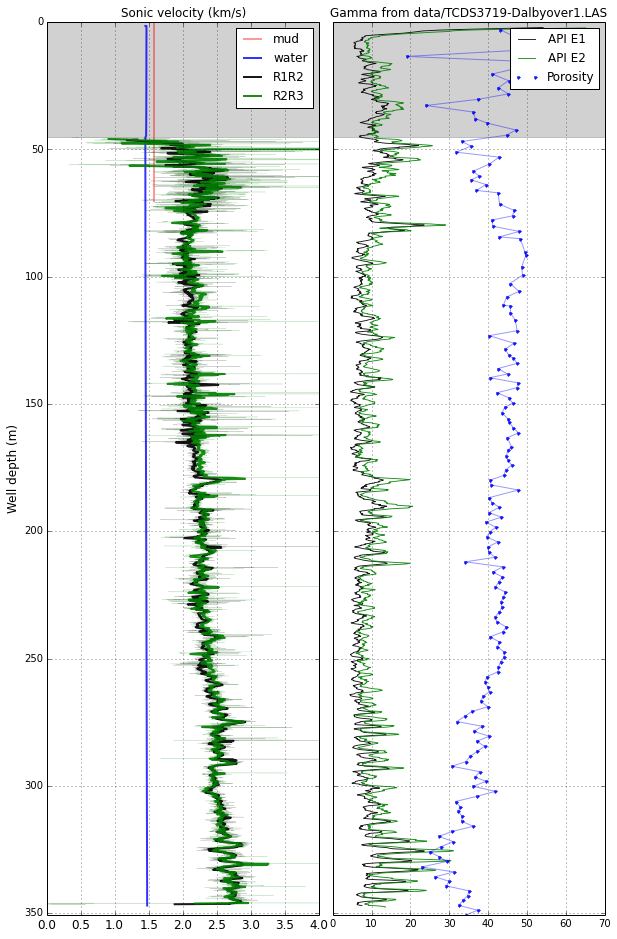

In [5]:
# Plot sonic

def well_plot(x,y=data['DEPTH'],label=None,lw=1,color='black',alpha=0.9):
    '''
    Using matplotlib to plot a well log. 
    '''
    plt.plot(x,y,label = label,lw = lw, color=color, alpha=alpha)
    plt.ylim(max(data['DEPTH']),0)
    return

def casing_plot():
    '''
    Plot casing , label='casing'
    '''
    return plt.axhspan(0,casing, facecolor='k', alpha=0.18)

def smooth_filter(raw,kernel=51):
    '''
    Apply median filter, set window size. Must be odd number. 
    '''
    raw = signal.medfilt(raw, kernel_size=5)
    return pd.rolling_mean(raw, kernel)

# Apply smoothing filter kernel is median window size, must be odd
kernel=60

fig = plt.figure(figsize=(10,16))
fig.subplots_adjust(wspace=0.05)

ax1 = plt.subplot(121)
ax1.set_ylim(ax1.get_ylim()[::-1]) 
plt.title('Sonic velocity (km/s)', fontsize = 12)
plt.ylabel('Well depth (m)', fontsize = 12)

#Plot mud velocity 5,300 feet/s
avg_temp = 0.5*(data['TEMP_E1']+data['TEMP_E2'])
plt.axvline(x=1.581, color='red', label='mud',lw=2,alpha=0.4,ymin=0.8)
plt.plot((1404.3+4.7*avg_temp+0.04*avg_temp**2)/1000,data['DEPTH'], lw=2, color='blue', label='water', alpha=0.8)

#well_plot(C*data['R1R2'],data['DEPTH']+0.1,'TEST!')

#def well_plot(x,y=data['DEPTH'],well_label='x',well_lw=1,well_color='black',well_alpha=0.9):

#Plot raw data
well_plot(data['R1R2'],data['DEPTH']+0.1, lw=0.3, alpha=0.3)
well_plot(data['R2R3'],data['DEPTH']-0.1, lw=0.3, color='green', alpha=0.3)
#R1R3

#Plot filtered data
well_plot(smooth_filter(C*data['R1R2'],kernel),data['DEPTH']+0.1, 
          label = 'R1R2',lw=2)
well_plot(smooth_filter(C*data['R2R3'],kernel),data['DEPTH']-0.1, 
          label = 'R2R3',lw=2, color='green')

casing_plot()

plt.setp(ax1.get_xticklabels(), fontsize=12)
plt.xlim(0, 4)
plt.grid()
plt.legend()

# Plot gamma
ax2 = plt.subplot(122, sharey=ax1)
plt.title('Gamma from %s'%in_electric[0], fontsize = 12)
well_plot(smooth_filter(data['NGAM_E1'],101), lw=0.9, label='API E1')
well_plot(smooth_filter(data['NGAM_E2'],101), lw=0.9, color ='green', label='API E2')

plt.xlim(0, 30)
plt.ylim(max(data['DEPTH']),0)
plt.setp(ax2.get_yticklabels(), visible=False)
casing_plot()

# Plot porosity
mask = np.isfinite(data['POROSITY'])
plt.plot(data['POROSITY'][mask],data['DEPTH'][mask],'.b', alpha=0.9,label='Porosity')
plt.plot(data['POROSITY'][mask],data['DEPTH'][mask],'b-', alpha=0.4)

plt.xlim(0, 70)
plt.ylim(max(data['DEPTH']),0)
plt.setp(ax2.get_yticklabels(), visible=False)
plt.grid()
plt.legend()

plt.show()

Velocity for [water](http://www.sciencedirect.com/science/article/pii/S030156299800091X) as a function of temperature is plotted in blue. 
Sonic velocities in drill mud is in the range of 185-189 $\mu/ ft$. See [Petrowiki](http://petrowiki.org/Porosity_evaluation_with_acoustic_logging). The lower value is typical for salt mud and showed as a red line in sonic plot.

## Gamma for correlance
TCDS3719-Dalbyover1.LAS and TCDS3719-Dalbyover2.LAS contains conductivity, temperature and gamma logs. 

Gamma logs are used among other to correlate the datasets in depth. According to Kristian Sloth, the best dataset to trust is the  TCDS3719-Dalbyover1.LAS

A closer look at the gamma logs:

          NGAM_E1   NGAM_E2    NGAM_G      NGTR
NGAM_E1  1.000000  0.813882  0.058149  0.434795
NGAM_E2  0.813882  1.000000  0.065101  0.454611
NGAM_G   0.058149  0.065101  1.000000  0.033056
NGTR     0.434795  0.454611  0.033056  1.000000

NGAM_E1 7.96 0.0
NGTR 9.84634 1.88634
NGAM_G 8.94 0.98
NGAM_E2 10.25 2.29


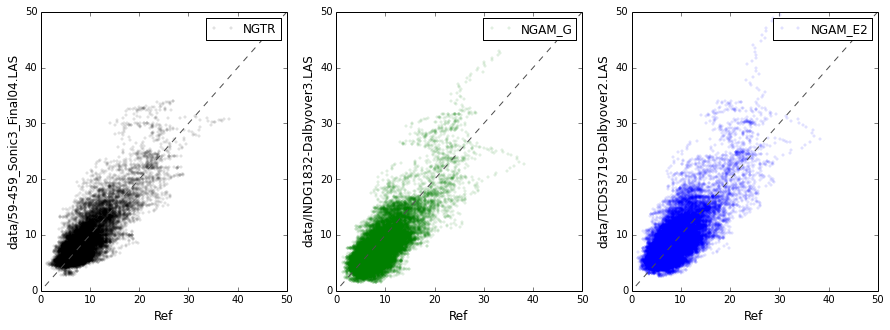

In [6]:
def corr_plot(x,corr_color,corr_label,y_label,sub):
    dc_corr = data[i].median()-ref_median
    ax = plt.subplot(sub)
    plt.plot(ref, x-dc_corr, corr_color, label = corr_label, alpha = 0.1, markersize=5,markevery=1)
    plt.legend()
    plt.xlabel('Ref', fontsize = 12)
    plt.ylabel(y_label, fontsize = 12)
    ax.plot([-75, 75], [-75, 75], ls="--", c=".3")
    plt.xlim(0, 50)
    plt.ylim(0, 50)
    return; 

# According to Kristian Sloth, the most relyable dataset 
ref= data['NGAM_E1'].values
ref_median = data['NGAM_E1'].median()

#List correlation
gamma_corr = pd.concat([data['NGAM_E1'], data['NGAM_E2'], 
                        data['NGAM_G'], data['NGTR']], axis=1)

corr = gamma_corr.corr(method='pearson', min_periods=1)
print corr
print

for i in ['NGAM_E1','NGTR','NGAM_G','NGAM_E2']:
    i_median = data[i].median()
    print i, i_median,  i_median-ref_median

# Plot correlation
fig = plt.figure(figsize=(15,5))
corr_plot(smooth_filter(data['NGTR']),'k.','NGTR',in_sonic,131)
corr_plot(smooth_filter(data['NGAM_G']),'g.','NGAM_G',in_gamma,132)
corr_plot(smooth_filter(data['NGAM_E2']),'b.','NGAM_E2',in_electric[1],133)


                   
plt.show()


The plot suggest that the gamma logs fit each other somehow, andwe can assume that the logs are adjusted coectely in depth. The gamma logs for correlation is corrected for dc by subtraction of the median value as: 

It apears that there is a rather good correlance between the electric logs, but not between electric and sonic log, especially for lower values. 

Archie's law links electrical conductivity to porosity and brine saturation. The electric tool conductivity log looks filtered, whiles the 'gamma' log is more spiky. Another challange is that there is a facor 50 diffeerence between the two. 

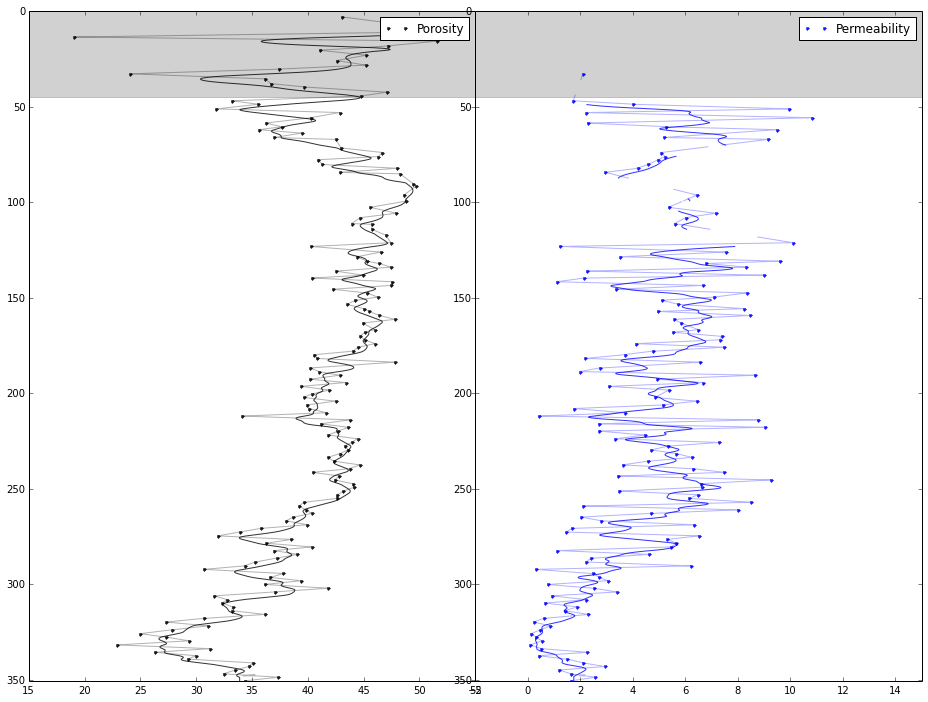

In [7]:
fig = plt.figure(figsize=(16,12))
fig.subplots_adjust(wspace=0)

ax1 = plt.subplot(121)
mask = np.isfinite(data['POROSITY'])
plt.plot(data['POROSITY'][mask],data['DEPTH'][mask],'.k', alpha=0.9,label='Porosity')
POR_inter = data['POROSITY'].interpolate(method='slinear', order=2,limit=300, limit_direction='both')
plt.plot(POR_inter,data['DEPTH'],'k-', alpha=0.3)
#plt.xlim(-2,15)
plt.plot(smooth_filter(POR_inter,500),data['DEPTH'],'k-', alpha=0.8)
plt.ylim(max(data['DEPTH']),0)
casing_plot()
plt.legend()
plt.ylim(max(data['DEPTH']),0)

ax2 = plt.subplot(122)
mask = np.isfinite(data['PERMEABILITY'])
plt.plot(data['PERMEABILITY'][mask],data['DEPTH'][mask],'.b', alpha=0.9,label='Permeability')
PERM_inter = data['PERMEABILITY'].interpolate(method='slinear', order=2,limit=300, limit_direction='both')
plt.plot(PERM_inter,data['DEPTH'],'b-', alpha=0.3)
plt.xlim(-2,15)
plt.plot(smooth_filter(PERM_inter,500),data['DEPTH'],'b-', alpha=0.8)

casing_plot()
plt.legend()
plt.ylim(max(data['DEPTH']),0)

plt.show()


Porosity and permeability can indicate lithology, as shown by Akbar et al:

<img src="images/Akbar_et_al.png" alt="Drawing" style="width: 400px;"/>

And ploted with plug data:

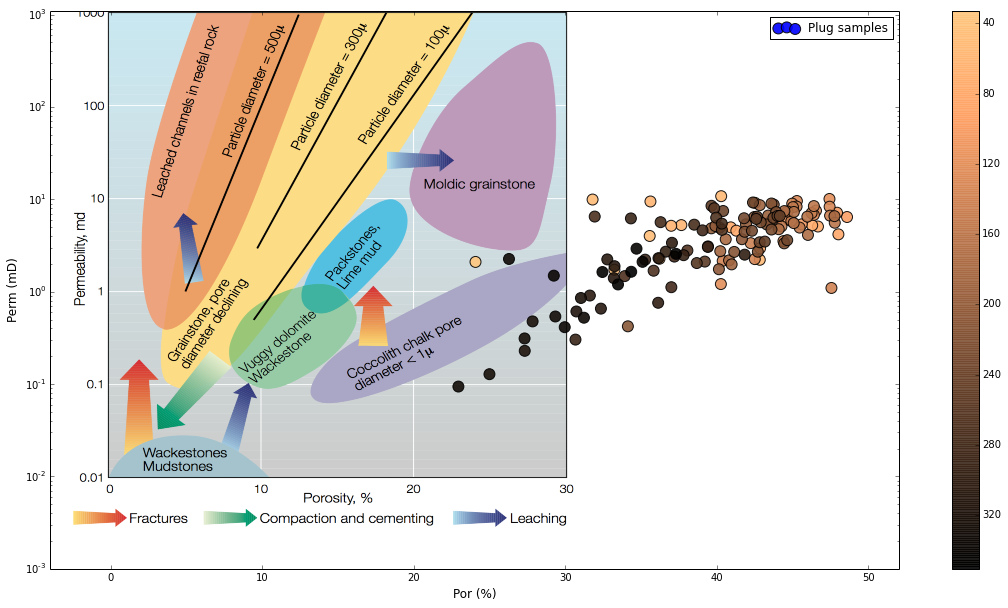

In [42]:
PERM_inter = data['PERMEABILITY'].interpolate(method='slinear', order=2,limit=300, limit_direction='both')
POR_inter = data['POROSITY'].interpolate(method='slinear', order=2,limit=300, limit_direction='both')

fig = plt.figure(figsize=(19,10))
ax = plt.gca()

mask = np.isfinite(data['POROSITY'])
color_depth = data['DEPTH'][mask]
#cm = plt.cm.get_cmap('RdYlBu')

por_per = ax.scatter(data['POROSITY'][mask], data['PERMEABILITY'][mask], 
                     c=color_depth, s=120, label='Plug samples', cmap='copper_r', alpha=0.9)
ax.set_yscale('log')
cbar=plt.colorbar(por_per)
cbar.ax.invert_yaxis() 
plt.legend()
plt.xlabel('Por (%)', fontsize = 12)
plt.ylabel('Perm (mD)', fontsize = 12)
plt.xlim(-4, 52)
plt.ylim(0.001, 1100)

im = plt.imread('images/Akbar_et_al.png')
plt.imshow(im, extent=[-4.5, 31.4, 0.002, 1500],interpolation='bicubic')

plt.show()

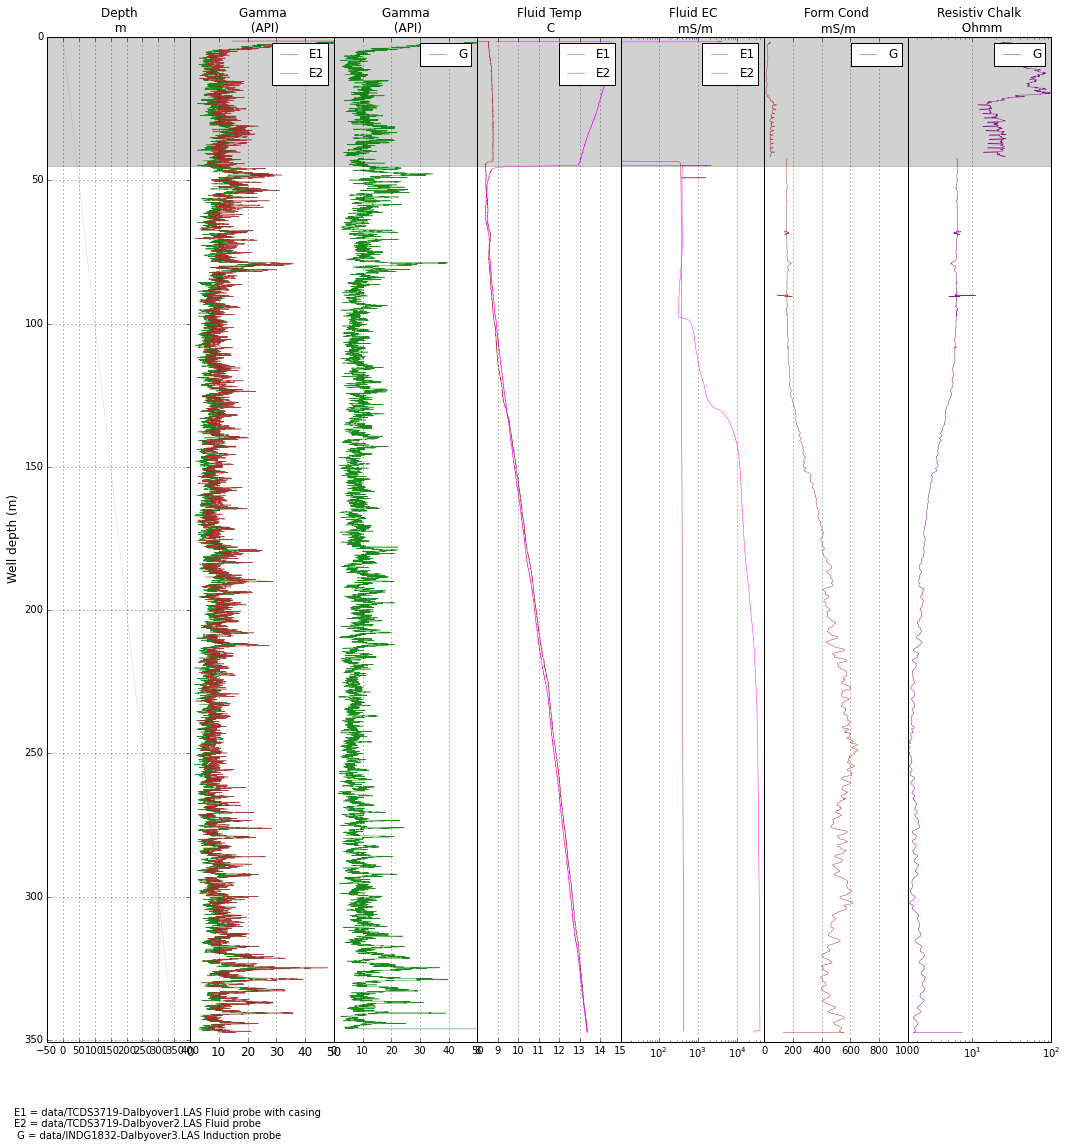

In [25]:
# Apply smoothing filter kernel is median window size, must be odd
kernel=99

fig = plt.figure(figsize=(18,18))
fig.subplots_adjust(wspace=0.0)
plt.xticks(rotation='vertical')

plt.figtext(.1, .05, 'E1 = %s Fluid probe with casing \nE2 = %s Fluid probe \n G = %s Induction probe'%(in_electric[0],in_electric[1],in_gamma))


#Depth
ax0 = plt.subplot(171) 
well_plot(data['DEPTH'],data['DEPTH'], lw=0.1, alpha=0.7)
plt.ylabel('Well depth (m)', fontsize = 12)
plt.title('Depth \n m', fontsize = 12)
plt.grid()
casing_plot()

#Gamma NG TCDS og NG casing
ax1 = plt.subplot(172)
well_plot(data['NGAM_E1'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'green', label='E1')
well_plot(data['NGAM_E2'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='E2')
plt.title('Gamma \n (API)', fontsize = 12)
plt.xlim(0, 50)
ax1.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#Natural Gamma
ax2=plt.subplot(173)
well_plot(data['NGAM_G'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'green', label='G')
plt.title('Gamma \n (API)', fontsize = 12)
plt.xlim(0, 50)
ax2.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#Temp
ax3=plt.subplot(174)
well_plot(data['TEMP_E1'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='E1')
well_plot(data['TEMP_E2'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'magenta', label='E2')
plt.title('Fluid Temp \n C', fontsize = 12)
plt.xlim(8, 15)
ax3.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#fluid conductivity
ax4=plt.subplot(175)
well_plot(data['COND_E1'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='E1')
well_plot(data['COND_E2'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'magenta', label='E2')
# in casing...
plt.title('Fluid EC \n mS/m', fontsize = 12)
ax4.set_xscale('log')
plt.xlim(0, 50000)
ax4.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#formation conductivity
ax5=plt.subplot(176)
well_plot(data['COND_G'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'brown', label='G')
plt.title('Form Cond \n mS/m', fontsize = 12)
plt.xlim(0, 1000)
ax5.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#R
ax6=plt.subplot(177)
well_plot(1000/data['COND_G'],data['DEPTH'], lw=0.5, alpha=0.9, color= 'purple', label='G')
plt.title('Resistiv Chalk \n Ohmm', fontsize = 12)
ax6.set_xscale('log')
plt.xlim(0, 100)
ax6.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

plt.setp(ax1.get_xticklabels(), fontsize=12)


plt.show()


Whit this information we can involve Archie's law and try to model the porosity based on electric logs, parameters and plug samples. 

$C_t = \frac{1}{a} C_w \phi^m S_w^n$

$C_t$ is the electrical conductivity of the fluid saturated rock
$a$ is the Tortuosity factor
$C_w$ is the electrical conductivity of the brine
$\phi$ is the porosity
$m$ is the cementation exponent
$S_w$ is the brine saturation
$n$ is saturation exponen

However, a better model kan be based on Katika and Fabricius(2015):

Kozeny’s equation relates porosity. permeability and pore space as (Kozeny, 1927): 

$k=c \frac{\phi}{s^2}$

and Carman’s model for the tortuous path (Carman, 1937):

$c_R=\frac{1}{k_0\tau}$

where $k_0$ is close to 2.

The model from Mortensen et. al. (1998) connects Kozeny’s factor with porosity for chalk:

$c_\phi=\frac{1}{(4\cos(\frac{1}{3}\arccos(\phi\frac{8^2}{\pi^3}-1)+\frac{4}{3}\pi)+4)}$
 

-12.1732851504


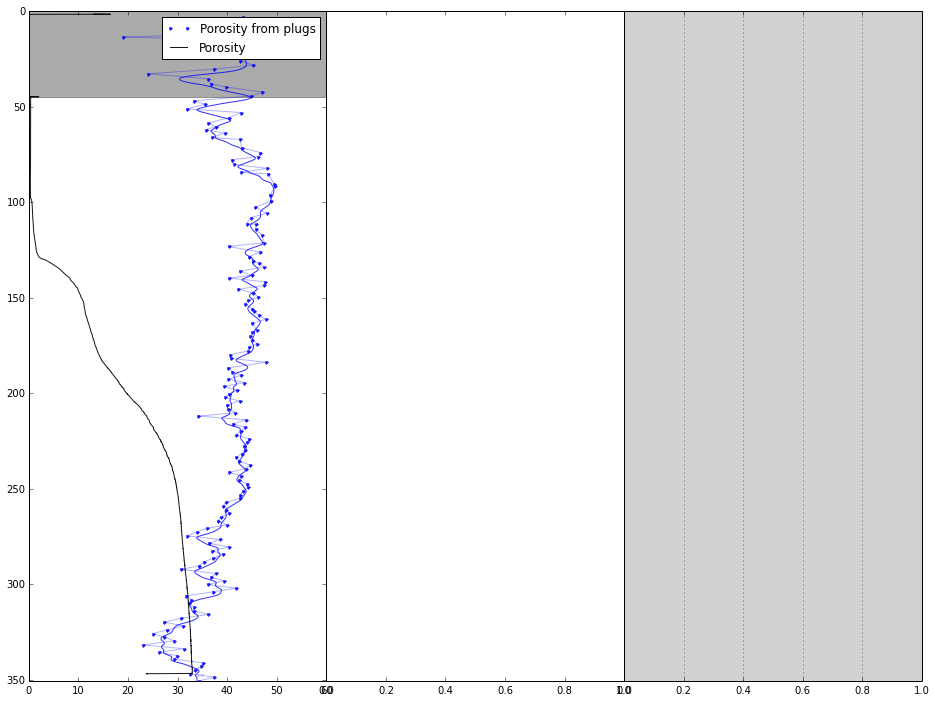

In [38]:
fig = plt.figure(figsize=(16,12))
fig.subplots_adjust(wspace=0)

def mortensen(c_phi):
    '''
    Calculate Kozeny’s factor with porosity
    From Mortenssen et al 1998
    x = $c_phi$
    '''
    return 4*math.cos((1/3)*math.acos(c_phi*64/math.pi**3-1)+math.pi*4/3+4)**(-1)

print mortensen(0.9)

#Archie's porosity
ax1 = plt.subplot(132)
Ct = data['COND_E2']/1000
a = 0.6 # Find for chalk
Cw = data['COND_E1']/1000
m = 2.36 # Check Olsen paper, Witthüser  et al: 2.36
Sw = 1 # Find temperature formula
n = 2 #Wettability

#Interpolated plug data
ax0 = plt.subplot(131)
mask = np.isfinite(data['POROSITY'])
plt.plot(data['POROSITY'][mask],data['DEPTH'][mask],'.b', alpha=0.9,label='Porosity from plugs')
plt.plot(POR_inter,data['DEPTH'],'b-', alpha=0.3)
well_plot(smooth_filter(POR_inter,500),data['DEPTH'], alpha=0.8,color= 'blue')
plt.grid()
plt.legend()
casing_plot()

Archies_porosity =(Ct*a/(Cw*Sw**n)**(1/m))

well_plot(Archies_porosity,color='k', label='Porosity')

ax1.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

#Archies porosity with samples and differences
ax2 = plt.subplot(133)
ax2.axes.get_yaxis().set_visible(False)
plt.grid()
plt.legend()
casing_plot()

plt.show()

To fix:
Make calculated velocities and show with tools velocities

Inspect data
Offset from gamma


Plot gamma logs and differences/variations
water mud curve with pressure and maybe salinity 
Archie's law See article
